# Chest X-Ray Images (Pneumonia)
**Authors:** Carlos McCrum, Jared Mitchell, Andrew Bernklau
***

## Overview
We've been tasked to build a model to classify images that consist of x-rays of infected and healthy lungs at our local hospital. The data contains thousands of images Mendeley Data. We start by preprocessing the images and splitting into training and test sets. Next we build different models to see what performs best, including Logistic Regression, Random Forest and Neural Networks. Convolutional neural networks performed best and had the best accuracy. So our recommendations would include convolutional neural networks for classification as they performed the best. 



***

## Business Problem

The number of Pneumonia cases increased in the last few years with 1.5 million ER visits and 2 million deaths indicating around 16% increase. The goal of our project is to build a image classification model that can correctly identify between x-rays of infected and healthy lungs so we can lower these numbers. It's important that our model has high accuracy and precision. With a low accuracy our model would misdiagnose too much or fail to diagnose someone who has pneumonia. Classifying images requires a lot of images for more accurate modeling and we are limited in the number of images we have at our disposal. We chose this route to see if modeling could help classify whether a person does or does not have a the Pneumonia to help radiology technicians at our local hospital.  

***

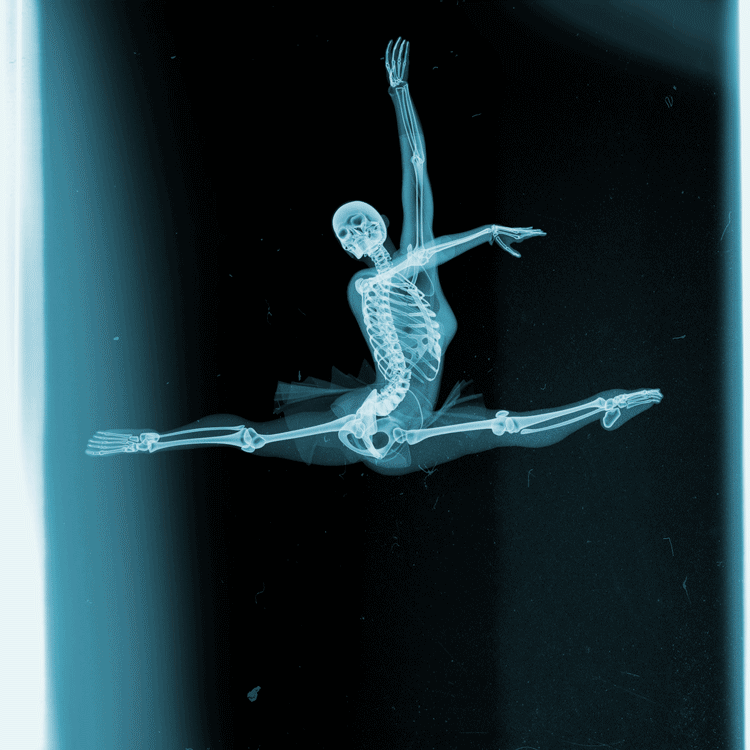

## Data Understanding

Our data comes from Mendeley Data, it contains a few thousand images Chest X-Ray described and analyzed in "Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning". The images are split into a training set and a testing set of independent patients. Images are labeled as (disease)-(randomized patient ID)-(image number by this patient). We are going to be classifying whether the images fall into the two classes either "NORMAL" or "PNEUMONIA"". We start buy preprocessing the data, then spliting it into training and validation sets then build a few different models to see what model perfoms best. 



***

In [1]:
# Import packages
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import plot_confusion_matrix
from tqdm import tqdm 
import code.preparation as prep
import code.visualization as viz
np.random.seed(123)
from tensorflow.keras import preprocessing
from time import time
from keras import layers
from keras import models
from keras import optimizers
import datetime
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import img_to_array
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

## Data Preparation

We preprocessed the data in two ways. One for our logistic and random forest models splitting our data the standard way, and the other we preprocessed our images into tensors for our neural network modeling. We did it this way to have our images properly set for our models for the best performance. There were very few images that would not load and were discarded, there were no other null values in our data. 

***

### Preprocessing

Set path for our images.

In [2]:
train_path = 'data/chest_xray/train/'
test_path = 'data/chest_xray/test/'
val_path = 'data/chest_xray/val'

Load ImageDataGenerator funtion to our different train, test, and validation sets. 

In [3]:
train_gen, test_gen, val_gen = prep.img_data_gen(train_path, test_path, val_path)

Found 5219 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


- Create datasets with correspoding images and labels and reshape for our models to interpret. 

In [4]:
# create the data sets
start = time()
val_images, val_labels = tqdm(next(val_gen))
test_images, test_labels = tqdm(next(test_gen))
train_images, train_labels = tqdm(next(train_gen))
end = time()

print("Total run Time:", round((end - start)/60, 2), "Min")

100%|██████████| 2/2 [00:00<00:00, 11966.63it/s]

Total run Time: 2.0 Min


Convert our image arrays to a proper shape for our models.

In [5]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

(5217, 65536)
(624, 65536)
(16, 65536)


Convert our labels to proper shape. 

In [6]:
train_y = np.reshape(train_labels[:,0], (5217,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

### Image EDA

Iterate through the training data to preview a small assortment of images to see if the labels match with the image. 

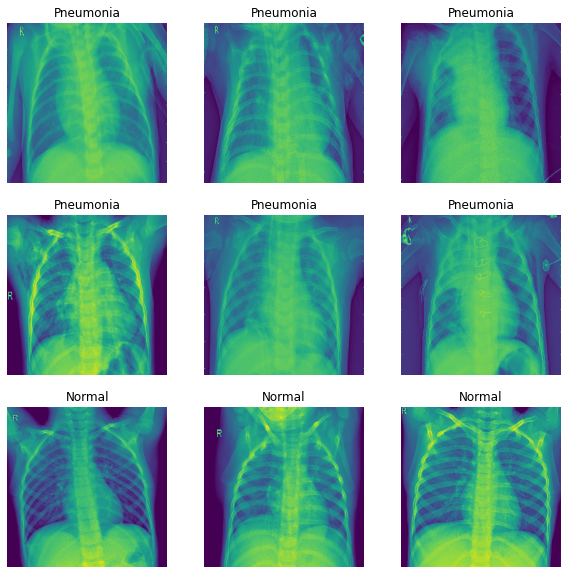

In [7]:
viz.preview_img(train_images, train_y)

Here we iterate through all the images in our training data to find the mean pixels of a normal x-ray lung and the mean of a lung with pneumonia. We then take the difference to visualize the contrast between the two throughout the entire training dataset with over 5000 images to get our average contrast. 

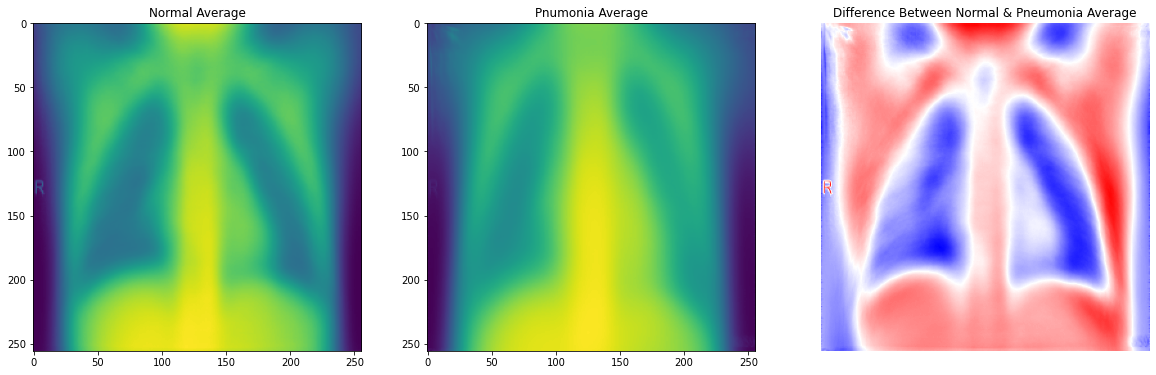

In [8]:
viz.view_img_mean(train_images, train_y)

Now we iterate through the training data labels to see if we have any class imbalance. 

Pneumonia    0.742764
Normal       0.257236
dtype: float64


<AxesSubplot:ylabel='count'>

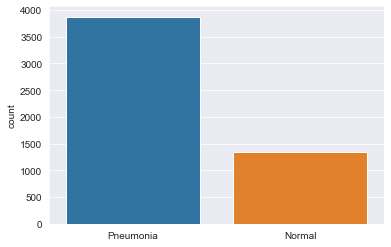

In [9]:
viz.class_inbalance(train_labels)

We see we have a slight class imbalance. To remedy this we will use sklearn to compute the class weights for us to use in our model giving more weight to the normal class to help balance out our imbalance. 

In [10]:
# Import class_weight from sklearn
from sklearn.utils import class_weight

# Set class weight to balanced and feed it the unique classes in our set.
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_gen.classes),
                                        y = train_gen.classes)     

# Convert class weights to dictionary format and zip together                                   
class_weights = dict(zip(np.unique(train_gen.classes), class_weights))

class_weights 

{0: 1.9444858420268256, 1: 0.6730719628578798}

## Data Modeling
We start off with a simple logistical regression model to see how it performs, we next move on to random forest modeling to see if we can get a better accuracy score, last we try convolutional neural networks to see how accurate we can make it so we don't have any false positives or false negatives. These are all models that work for classification, let's see how they perform. 

***

Start by running a logistical regression model with l2 regularization as our baseline. 

In [11]:
start = time()

prep.logistic_regression_l2(train_img, train_y, test_img, test_y)

end = time()
print("Total run Time:", round((end - start)/60, 2), "Min")

Accuracy test score of logistic regression model with L2 regularization: 0.7419871794871795
Total run Time: 0.62 Min


Very good start, now we move on to our random forest to see if we can improve the accuracy of the results. 

In [12]:
start = time()

RF_model = prep.random_forest(train_img, train_y, test_img, test_y)

end = time()
print("Total run Time:", round((end - start)/60, 2), "Min")

Cross validation score for Random Forest: [0.912      0.872      0.896      0.864      0.88709677]
Accuracy test score of random forest model: 0.7852564102564102
Total run Time: 0.84 Min


Plot confusion matrix to visualize at how well our model classified our images. 

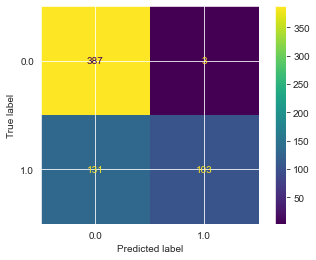

In [13]:
plot_confusion_matrix(RF_model, test_img, test_y);

Now we will try a convolutional neural network (CNN) as it is exceptional at image processing. We can utilize the convolutional operation to detect more complex features within the image. Let's start with one Conv2d and one MaxPooling2D layer.

#### Baseline CNN

In [14]:
start = time()

history = prep.first_cnn(train_images, train_y, val_images, val_y, test_images, test_y)

end = time()

print("Total run Time:", round((end - start)/60, 2), "Min")

Epoch 1/20
20/20 [==============================] - 10s 413ms/step - loss: 0.7432 - precision_at_recall: 0.3484 - val_loss: 1.1790 - val_precision_at_recall: 1.0000
Epoch 2/20
20/20 [==============================] - 8s 383ms/step - loss: 0.6574 - precision_at_recall: 0.3790 - val_loss: 1.1069 - val_precision_at_recall: 1.0000
Epoch 3/20
20/20 [==============================] - 8s 396ms/step - loss: 0.6628 - precision_at_recall: 0.4906 - val_loss: 0.8737 - val_precision_at_recall: 1.0000
Epoch 4/20
20/20 [==============================] - 8s 392ms/step - loss: 0.6107 - precision_at_recall: 0.4886 - val_loss: 0.9557 - val_precision_at_recall: 1.0000
Epoch 5/20
20/20 [==============================] - 8s 383ms/step - loss: 0.5509 - precision_at_recall: 0.6290 - val_loss: 1.1372 - val_precision_at_recall: 1.0000
Epoch 6/20
20/20 [==============================] - 8s 384ms/step - loss: 0.5180 - precision_at_recall: 0.6508 - val_loss: 0.8594 - val_precision_at_recall: 1.0000
Epoch 7/20
20/2

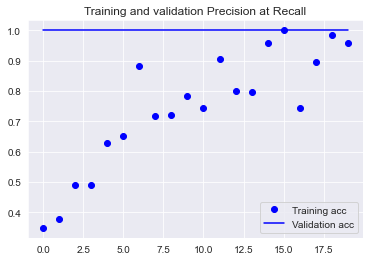

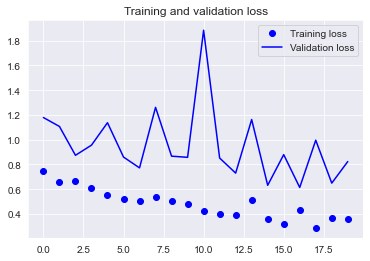

In [15]:
viz.accuracy_and_losses(history);

That CNN did pretty good but there does seem to be some overfitting issues. Now we will add some layers and tuning to the CNN for improvement and adding more layers such as dropout and other regularization tecniques to see if we can reduce overfitting and increase our precision. 

### Model training with keras tensor objects

Now were going to load the data similar as before but this time we are going to batch our images and plug them directly into our model for training.

In [30]:
train_gen, test_gen, val_gen = prep.img_data_gen_batched(train_path, test_path, val_path)

Found 5219 images belonging to 2 classes.
Found 625 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


For this model we used four convolutional layers, a few dropout layers, a few batch normalization layers and some maxpool2d layers. We also inserted data augmentation layers, these work by flipping and translating images to different heights and widths to give our model more to work with.  

In [17]:
start = time()

history = prep.final_model(train_gen, val_gen, test_gen)

end = time()

print("Total Run Time:", round((end - start)/60/60, 2), "HOURS")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 random_translation (RandomT  (None, 128, 128, 32)     0         
 ranslation)                                                     
                                                                 
 random_flip (RandomFlip)    (None, 128, 128, 32)      0         
                                                      

In [31]:
model = load_model('Models/best_model_precision_recall.h5', compile=True)
print(f"\nTest Score: {model.evaluate(test_gen)[1]}")

40/40 [==============================] - 25s 599ms/step - loss: 0.3061 - precision_at_recall_1: 0.9843

Test Score: 0.9843260049819946


This model took a while to run but recived a pretty good result with about a 98% precision where recall is set to a .5 threshold. The best model was saved and utilized in classifying images for deployment. 

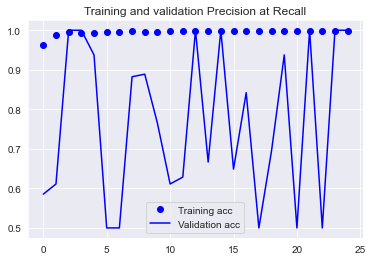

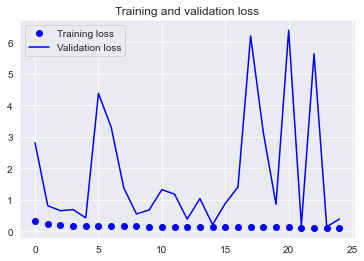

In [20]:
def accuracy_and_losses(history):
    acc = history.history['precision_at_recall_1']
    val_acc = history.history['val_precision_at_recall_1']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation Precision at Recall')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    return plt.show()
accuracy_and_losses(history);

## Evaluation
Our best model came out to 90% accuracy score and a 98% precision at a .5 recall score. After using dropout and other regularization techniques we our final model did better than either our logistic regression or random forest models. This shows us that our convolutional neural networks are working great by classifying our images. Our baseline with logistic regression was 74% which still fairy good, though on our final model we've made a significant improvement with all the different layers to help with overfitting. With the accuracy our model will be able to help our business problem but not solve it, because our model could never be as good as a human in this circumstance. 

***

## Conclusions

Should not be used as a diagnosis, it is a good educational tool for new students or radiologist technicians. It has a good accuracy but doesn't fully solve our business problem because for our model to be used professionally in the medical field it would have to have near perfect accuracy. With more data and resources we might be able to get a more accurate model, that is something we can look into for future research.  
***